In [5]:
pre = None
a = None
if pre and a is None:
    print(1)
else:
    print(0)

0


In [6]:
# 画数据集真值pose的轨迹
import matplotlib.pyplot as plt
import numpy as np
pose_abs, pose_rel = read_pose_from_text("/data/lijingfeng/pro/Visual-Selective-VIO/data/poses/05.txt")
pose_abs = np.array(pose_abs)
pose_rel = np.array(pose_rel)
x = pose_abs[:,0,3]
y = pose_abs[:,1,3]
z = pose_abs[:,2,3]

#画图
style_gt = 'r-'
style_O = 'ko'
plot_keys = ["Ground Truth", "Ours"]
plt.plot(x, z, style_gt, label=plot_keys[0])
start_point = [0, 0]
ax = plt.gca()
plt.plot(start_point[0], start_point[1], style_O, label='Start Point')
plt.legend(loc="upper right", prop={'size': 10})
plt.xlabel('x (m)', fontsize=10)
plt.ylabel('z (m)', fontsize=10)
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xmean = np.mean(xlim)
ymean = np.mean(ylim)
plot_radius = max([abs(lim - mean_)
                   for lims, mean_ in ((xlim, xmean),
                                       (ylim, ymean))
                   for lim in lims])
ax.set_xlim([xmean - plot_radius, xmean + plot_radius])
ax.set_ylim([ymean - plot_radius, ymean + plot_radius])
plt.title('2D path')
plt.savefig("/data/lijingfeng/pro/Visual-Selective-VIO/seq05gt.png", bbox_inches='tight', pad_inches=0.1)


NameError: name 'read_pose_from_text' is not defined

In [ ]:
import numpy as np
import math
_EPS = np.finfo(float).eps * 4.0

path = "./data/poses/05.txt"
def read_pose_from_text(path):
    with open(path) as f:
        lines = [line.split('\n')[0] for line in f.readlines()]
        poses_rel, poses_abs = [], []
        values_p = read_pose(lines[0])
        poses_abs.append(values_p)            
        for i in range(1, len(lines)):
            values = read_pose(lines[i])
            poses_rel.append(get_relative_pose_6DoF(values_p, values)) 
            values_p = values.copy()
            poses_abs.append(values) 
        poses_abs = np.array(poses_abs)
        poses_rel = np.array(poses_rel)
        
    return poses_abs, poses_rel

def read_pose(line):
    '''
    Reading 4x4 pose matrix from .txt files
    input: a line of 12 parameters
    output: 4x4 numpy matrix
    '''
    values= np.reshape(np.array([float(value) for value in line.split(' ')]), (3, 4))
    Rt = np.concatenate((values, np.array([[0, 0, 0, 1]])), 0)
    return Rt
  
def get_relative_pose(Rt1, Rt2):
    '''
    Calculate the relative 4x4 pose matrix between two pose matrices
    '''
    Rt1_inv = np.linalg.inv(Rt1)
    Rt_rel = Rt1_inv @ Rt2
    return Rt_rel

def euler_from_matrix(matrix):
    '''
    Extract the eular angle from a rotation matrix
    '''
    M = np.array(matrix, dtype=np.float64, copy=False)[:3, :3]
    cy = math.sqrt(M[0, 0] * M[0, 0] + M[1, 0] * M[1, 0])
    ay = math.atan2(-M[2, 0], cy)
    if ay < -math.pi / 2 + _EPS and ay > -math.pi / 2 - _EPS:  # pitch = -90 deg
        ax = 0
        az = math.atan2(-M[1, 2], -M[0, 2])
    elif ay < math.pi / 2 + _EPS and ay > math.pi / 2 - _EPS:
        ax = 0
        az = math.atan2(M[1, 2], M[0, 2])
    else:
        ax = math.atan2(M[2, 1], M[2, 2])
        az = math.atan2(M[1, 0], M[0, 0])
    return np.array([ax, ay, az])

def get_relative_pose_6DoF(Rt1, Rt2):
    '''
    Calculate the relative rotation and translation from two consecutive pose matrices 
    '''
    
    # Calculate the relative transformation Rt_rel
    Rt_rel = get_relative_pose(Rt1, Rt2)

    R_rel = Rt_rel[:3, :3]
    t_rel = Rt_rel[:3, 3]

    # Extract the Eular angle from the relative rotation matrix
    x, y, z = euler_from_matrix(R_rel)
    theta = [x, y, z]

    pose_rel = np.concatenate((theta, t_rel))
    return pose_rel

#接下来是path_accu将6DoF相对pose -> 绝对pose
#输入是6DoF的pose
def path_accu(pose):
    '''
    Generate the global pose matrices from a series of relative poses
    '''
    answer = [np.eye(4)]
    for index in range(pose.shape[0]):
        pose_ = pose_accu(answer[-1], pose[index, :])
        answer.append(pose_)
    return answer
def pose_accu(Rt_pre, R_rel):
    '''
    Calculate the accumulated pose from the latest pose and the relative rotation and translation
    '''
    Rt_rel = pose_6DoF_to_matrix(R_rel)
    return Rt_pre @ Rt_rel

def pose_6DoF_to_matrix(pose):
    '''
    Calculate the 3x4 transformation matrix from Eular angles and translation vector
    '''
    R = eulerAnglesToRotationMatrix(pose[:3])
    t = pose[3:].reshape(3, 1)
    R = np.concatenate((R, t), 1)
    R = np.concatenate((R, np.array([[0, 0, 0, 1]])), 0)
    return R

def eulerAnglesToRotationMatrix(theta):
    '''
    Calculate the rotation matrix from eular angles (roll, yaw, pitch)
    '''
    R_x = np.array([[1, 0, 0],
                    [0, np.cos(theta[0]), -np.sin(theta[0])],
                    [0, np.sin(theta[0]), np.cos(theta[0])]
                    ])
    R_y = np.array([[np.cos(theta[1]), 0, np.sin(theta[1])],
                    [0, 1, 0],
                    [-np.sin(theta[1]), 0, np.cos(theta[1])]
                    ])
    R_z = np.array([[np.cos(theta[2]), -np.sin(theta[2]), 0],
                    [np.sin(theta[2]), np.cos(theta[2]), 0],
                    [0, 0, 1]
                    ])
    R = np.dot(R_z, np.dot(R_y, R_x))
    return R

#poses_abs = N * 12
#poses_rel = 6DoF relative pose
poses_abs, poses_rel = read_pose_from_text(path=path)
global_gt_from_poses_rel = path_accu(poses_rel)
global_gt_from_poses_rel = np.array(global_gt_from_poses_rel)
global_gt_from_poses_rel.shape
global_gt = global_gt_from_poses_rel.reshape((global_gt_from_poses_rel.shape[0],global_gt_from_poses_rel.shape[1]*global_gt_from_poses_rel.shape[2]))
global_gt = global_gt[:,:-4]
# global_gt[:,-4:]
np.savetxt("SVIO_gt_from_6DoF_rel_pose.txt", global_gt)

In [ ]:
# rearrage底层逻辑
import torch
from einops import rearrange, repeat

a1 = torch.ones((1,2,512))
a0 = torch.zeros((1,2,512))

a = torch.cat((a1,a0),dim=0)
print(a)
a = rearrange(a, 'b t d -> (b t) d',b=2,t=2)
print(a)

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]])
tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])


In [ ]:
import torch
attn_weights = torch.rand(12,2,513,513)
cams = attn_weights.sum(0)[:, 0, 1:].reshape([2, 16, 32]).unsqueeze(1)
cams.shape

/data/lijingfeng/anaconda3/envs/SVIO/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


torch.Size([2, 1, 16, 32])

In [ ]:
# plot code 以及存储地址
## 1
import matplotlib.pyplot as plt
plt.imshow(attn_map[0][0].data.cpu().numpy())
plt.colorbar()#只需要第一张图使用，接下来不需要
plt.savefig("attn/attn0_0.png")

## 2
from torchvision import transforms
toPIL = transforms.ToPILImage()
pic = toPIL(attn_map[1][1])
pic.save("attn0.png")

cam可视化的构建，与原图相比较更关注哪些区域

In [2]:
# cam可视化
from PIL import Image
import numpy as np
import cv2
import torch.nn as nn
import matplotlib.pyplot as plt
import torch
from model import CAM
import argparse
from einops import rearrange, repeat

class Encoder_CAM(nn.Module):
    def __init__(self):
        super(Encoder_CAM, self).__init__()
        # CNN
        self.T = 2
        self.seq_len = 11
        img_h = 256
        img_w = 512
        patch_size = 16
        self.token_h = int(img_h / patch_size)
        self.token_w = int(img_w / patch_size)
        self.visual_encoder = CAM((256,512), patch_size, in_chans=3, num_classes=512, embed_dim=512, depth=8)
        self.head = nn.Linear(512,6)
    def forward(self, img):
        # shape=[16,10,2,3,256,512]
        v = torch.cat((img[:, :-1].unsqueeze(2), img[:, 1:].unsqueeze(2)), dim=2)
        batch_size = v.size(0)
        seq_len = v.size(1)
        device = img.device
        # image CNN
        # v = v.view(batch_size * seq_len, v.size(2), v.size(3), v.size(4), v.size(5))
        #自己加入TSformer内容
        cls_token = []
        patch_token = []
        attn_weights = []
        for i in range(v.size(1)):
             ctmp, ptmp, attn_map = self.visual_encoder(v[:,i])
             cls_token.append(ctmp)
             patch_token.append(ptmp)
             attn_weights.append(attn_map)

        cls_token = torch.stack(cls_token,dim=1).to(device)
        # 对两张图求patch token 求mean,这个实验名字叫ts_cam,接下来做cls_token做预测
        # vf_mean = torch.mean(v_f,dim=2)
        est_pose = self.head(cls_token)
        # 得到cam时会用得着
        if not self.training:
            # patch feature map
            patch_token = torch.stack(patch_token,dim=1).squeeze(0).to(device)# seq,(t h w),dim
            patch_token = rearrange(patch_token, 's (t h w) d -> s t h w d',t=self.T,h=self.token_h,w=self.token_w)
            # block and head维度怎么处理
            attn_weights = torch.stack(attn_weights,dim=0)# shape = [seq,block,(b t),head,c+p_tokens,c+p_tokens]
            attn_weights = torch.mean(attn_weights,dim=3)# mean head维度

            attn_map_last_layer = attn_weights[:,-1,:,0,1:]
            attn_weights = attn_weights.sum(1)
            attn_map = attn_weights[:, :, 0, 1:] # block 做 sum
            attn_map = rearrange(attn_map,'s t (h w) -> s t h w',h=self.token_h,w=self.token_w)
            # attn_map=[seq,t,h,w], patch_token=[seq,t,h,w,dim]
            #这只是一张图的cam
            cam0 = attn_map[0][0] * patch_token[0][0].permute(2,0,1)
            cam1 = attn_map[0][1] * patch_token[0][1].permute(2,0,1)
            
        return attn_map, patch_token, cam0, cam1, attn_map_last_layer

model = Encoder_CAM()
model = model.cuda()
checkpoint = torch.load("./results/ts_cam_cls/checkpoints/046_copy.pth")
model.load_state_dict(checkpoint)
model.eval()


Encoder_CAM(
  (visual_encoder): CAM(
    (dropout): Dropout(p=0.0, inplace=False)
    (patch_embed): PatchEmbed(
      (proj): Conv2d(3, 512, kernel_size=(16, 16), stride=(16, 16))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (time_drop): Dropout(p=0.0, inplace=False)
    (blocks): ModuleList(
      (0): Block(
        (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (attn): Attention(
          (qkv): Linear(in_features=512, out_features=1536, bias=False)
          (proj): Linear(in_features=512, out_features=512, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
          (attn_drop): Dropout(p=0.0, inplace=False)
        )
        (temporal_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (temporal_attn): Attention(
          (qkv): Linear(in_features=512, out_features=1536, bias=False)
          (proj): Linear(in_features=512, out_features=512, bias=True)
          (proj_drop): Dropout(p=0.0, inplace=False)
      

In [3]:
# 这里与ts-cam不一样的点在于需要两张连续图来做transformer，做可视化
from torchvision import transforms
im0 = Image.open("./data/sequences/00/image_2/000100.png").convert('RGB')
im1 = Image.open("./data/sequences/00/image_2/000103.png").convert('RGB')
transform = transforms.Compose([
    transforms.Resize((256, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
x0 = transform(im0)
x1 = transform(im1)
# x.size()
im0

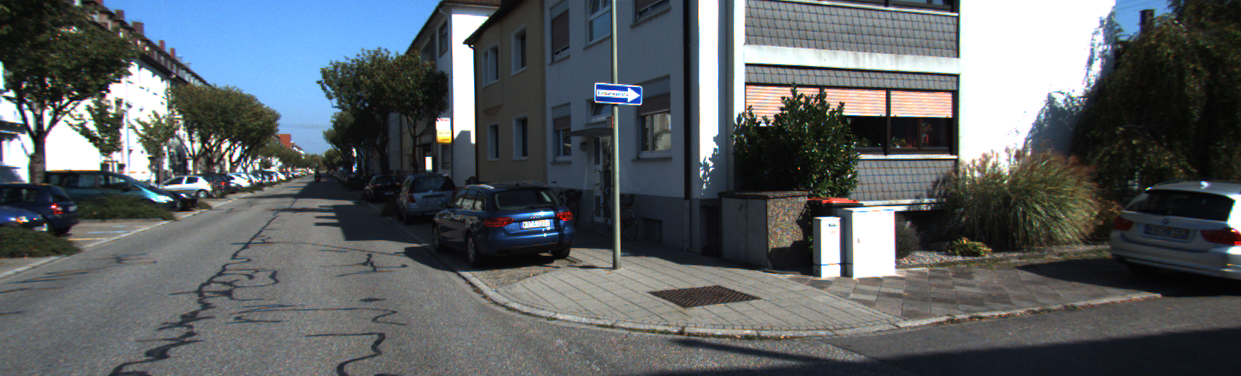

In [4]:
im1

In [5]:
#构建可以输入模型的数据格式
x = torch.stack((x0,x1))
x.shape

torch.Size([2, 3, 256, 512])

In [6]:
with torch.no_grad():
    attn_map, patch_token, tscams0, tscams1, attn_map_last_layer = model(x.unsqueeze(0).cuda())
print(tscams0.shape)
print(tscams1.shape)

torch.Size([512, 16, 32])
torch.Size([512, 16, 32])


In [7]:
tscams0 = tscams0.unsqueeze(0).unsqueeze(0)
tscams1 = tscams1.unsqueeze(0).unsqueeze(0)
print(tscams0.shape)
print(tscams1.shape)
print(attn_map.shape)
print(patch_token.shape)
print(attn_map_last_layer.shape)

torch.Size([1, 1, 512, 16, 32])
torch.Size([1, 1, 512, 16, 32])
torch.Size([1, 2, 16, 32])
torch.Size([1, 2, 16, 32, 512])
torch.Size([1, 2, 512])


In [8]:
# 对两张图可以通过下标寻址
images = [im0,im1]

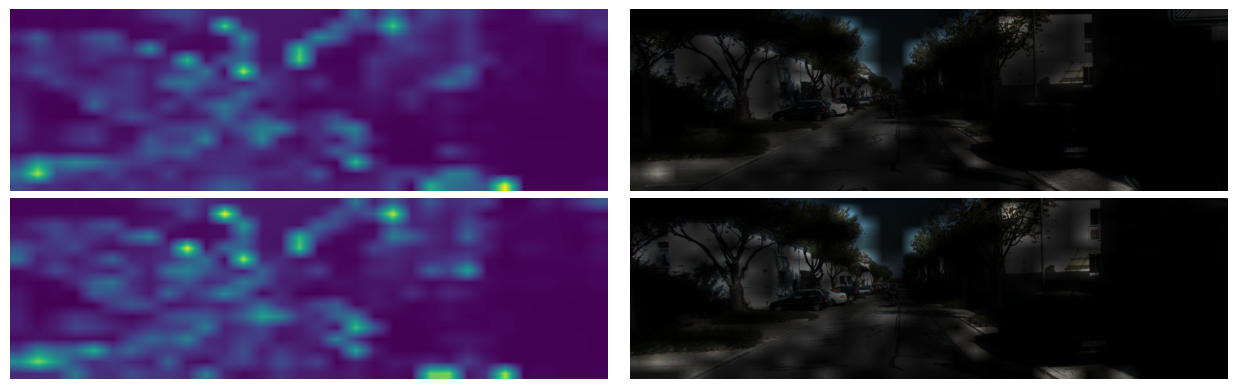

In [49]:
# 与下面代码一致，但是这里只显示attention map以及叠加原图之后的效果
import cv2
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(16, 4.8))
for i in range(2):
    attn_map_sum = attn_map[0,i].detach().cpu().numpy()
    attn_map_sum = cv2.resize(attn_map_sum, im0.size)
    attn_map_sum_min,attn_map_sum_max = attn_map_sum.min(),attn_map_sum.max()
    attn_map_sum = (attn_map_sum-attn_map_sum_min) / (attn_map_sum_max - attn_map_sum_min)
    # plt.imshow(cam.detach().cpu().numpy())
    mask_image = (attn_map_sum[..., np.newaxis] * images[i]).astype("uint8")
    axes[i][0].imshow(attn_map_sum)
    axes[i][0].axis('off')
    axes[i][1].imshow(mask_image)
    axes[i][1].axis('off')

plt.subplots_adjust(wspace=0.001, hspace=0.04)
# plt.colorbar()#只需要第一张图使用，接下来不需要
%matplotlib inline
plt.show()

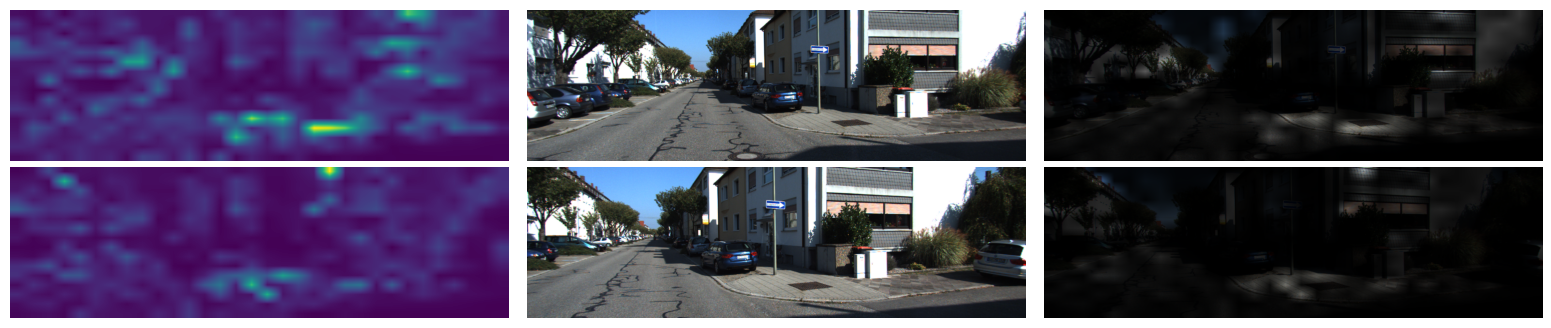

In [9]:
# attntion map（所有layer sum）和原图叠加，出效果
# 发现attention关注的区域都基本相同，但是还不能解释加上imu
import cv2
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 4))
for i in range(2):
    attn_map_sum = attn_map[0,i].detach().cpu().numpy()
    attn_map_sum = cv2.resize(attn_map_sum, im0.size)
    attn_map_sum_min,attn_map_sum_max = attn_map_sum.min(),attn_map_sum.max()
    attn_map_sum = (attn_map_sum-attn_map_sum_min) / (attn_map_sum_max - attn_map_sum_min)
    # plt.imshow(cam.detach().cpu().numpy())
    mask_image = (attn_map_sum[..., np.newaxis] * images[i]).astype("uint8")
    axes[i][0].imshow(attn_map_sum)
    axes[i][0].axis('off')
    axes[i][1].imshow(images[i])
    axes[i][1].axis('off')
    axes[i][2].imshow(mask_image)
    axes[i][2].axis('off')

plt.subplots_adjust(wspace=0.001, hspace=0.04)
# plt.colorbar()#只需要第一张图使用，接下来不需要
%matplotlib inline
plt.show()

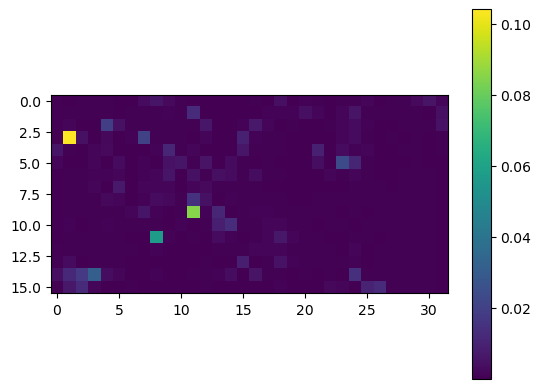

In [19]:
# 最后一层attention map
attn_map_last_layer1 = rearrange(attn_map_last_layer, 's t (h w) -> s t h w',h=16,w=32)
plt.imshow(attn_map_last_layer1[0,0].detach().cpu().numpy())
%matplotlib inline
# plt.colorbar()
plt.show()

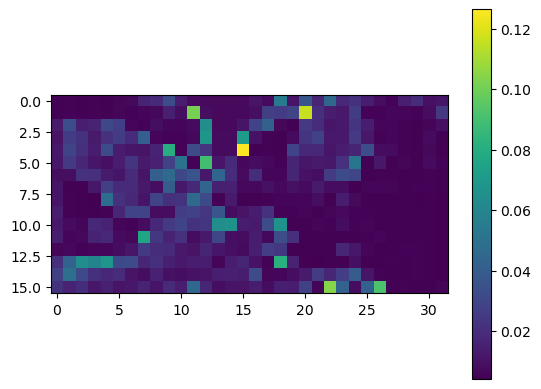

In [20]:
# 没有插值到原图，只是看16*32的值attntion值,block做sum得到的attention_map
# 想要显示多张，但是这样就不能有colorbar显示值的大小，没有改完全，不能直接使用
fig, axes = plt.subplots(nrows=2, figsize=(13, 4))
axes[0].imshow(attn_map[0,0].detach().cpu().numpy())
axes[i][0].axis('off')
plt.imshow(attn_map[0,0].detach().cpu().numpy())
# sum(attn_map[0][0][1])
plt.colorbar()
%matplotlib inline
plt.show()
# plt.colorbar()

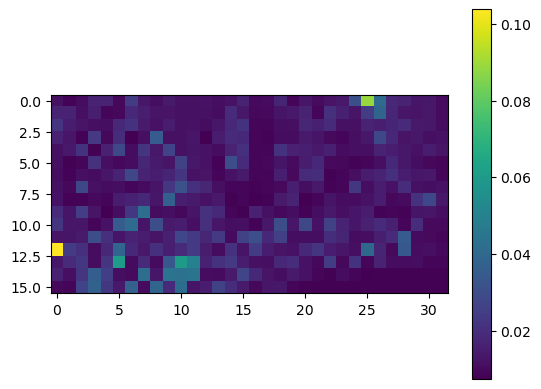

In [79]:
# 其实跟上一个一样，只是可以显示单张block做sum得到的attention map的图像
plt.imshow(attn_map[0,0].detach().cpu().numpy())
# sum(attn_map[0][0][1])
plt.colorbar()
%matplotlib inline
plt.show()
# plt.colorbar()

In [ ]:
# 基于上一块code改为显示两张图像attention map
fig, axes = plt.subplots(ncols=2, figsize=(16, 16))
axes[0].imshow(attn_map[0,0].detach().cpu().numpy())
axes[0].axis('off')
axes[1].imshow(attn_map[0,1].detach().cpu().numpy())
axes[1].axis('off')
plt.subplots_adjust(wspace=0.001, hspace=0.04)
# plt.colorbar()#只需要第一张图使用，接下来不需要
plt.show()

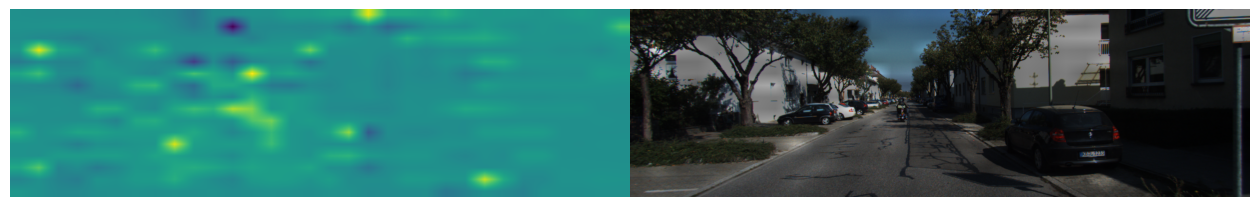

In [67]:
#所有channel求和得到的cam和原图叠加的效果
import cv2
cam = tscams.sum(2)[0][0].detach().cpu().numpy()
cam = cv2.resize(cam, im0.size)
cam_min,cam_max = cam.min(),cam.max()
cam = (cam-cam_min) / (cam_max - cam_min)
# plt.imshow(cam.detach().cpu().numpy())
mask_image = (cam[..., np.newaxis] * im0).astype("uint8")
fig, axes = plt.subplots(ncols=2, figsize=(16, 16))
axes[0].imshow(cam)
axes[0].axis('off')
axes[1].imshow(mask_image)
axes[1].axis('off')
plt.subplots_adjust(wspace=0.001, hspace=0.04)
# plt.colorbar()#只需要第一张图使用，接下来不需要
plt.show()
# plt.imshow(mask_image)


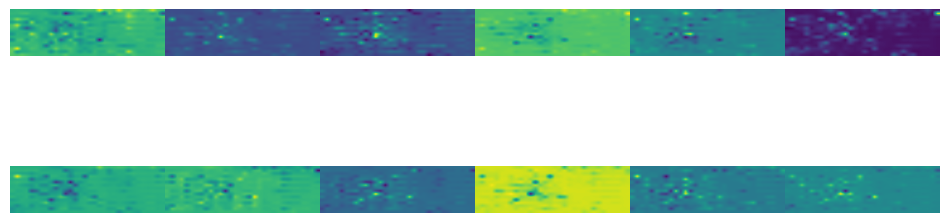

In [70]:
# 显示不同channel的图像
"""
Visualize more attention maps from 1-12 layer,for class token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
left = 0.1  # the left side of the subplots of the figure
right = 0.9   # the right side of the subplots of the figure
bottom = 0.1  # the bottom of the subplots of the figure
top = 0.4     # the top of the subplots of the figure
wspace = 0.05  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.02  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 4))
for row in range(2):
    for col in range(6):
        cam_pred = tscams0[0,0,row*6+col].detach().cpu().numpy()
        mask_pred = cv2.resize(cam_pred, im0.size)
        mask_min_v, mask_max_v = mask_pred.min(), mask_pred.max()
        mask_pred = (mask_pred - mask_min_v) / (mask_max_v - mask_min_v)
        mask_image = (mask_pred[..., np.newaxis] * im0).astype("uint8")
        axes[row][col].imshow(mask_pred)
        axes[row][col].axis('off')
plt.subplots_adjust(wspace=0.001, hspace=0.04)
# plt.colorbar()#只需要第一张图使用，接下来不需要
plt.show()

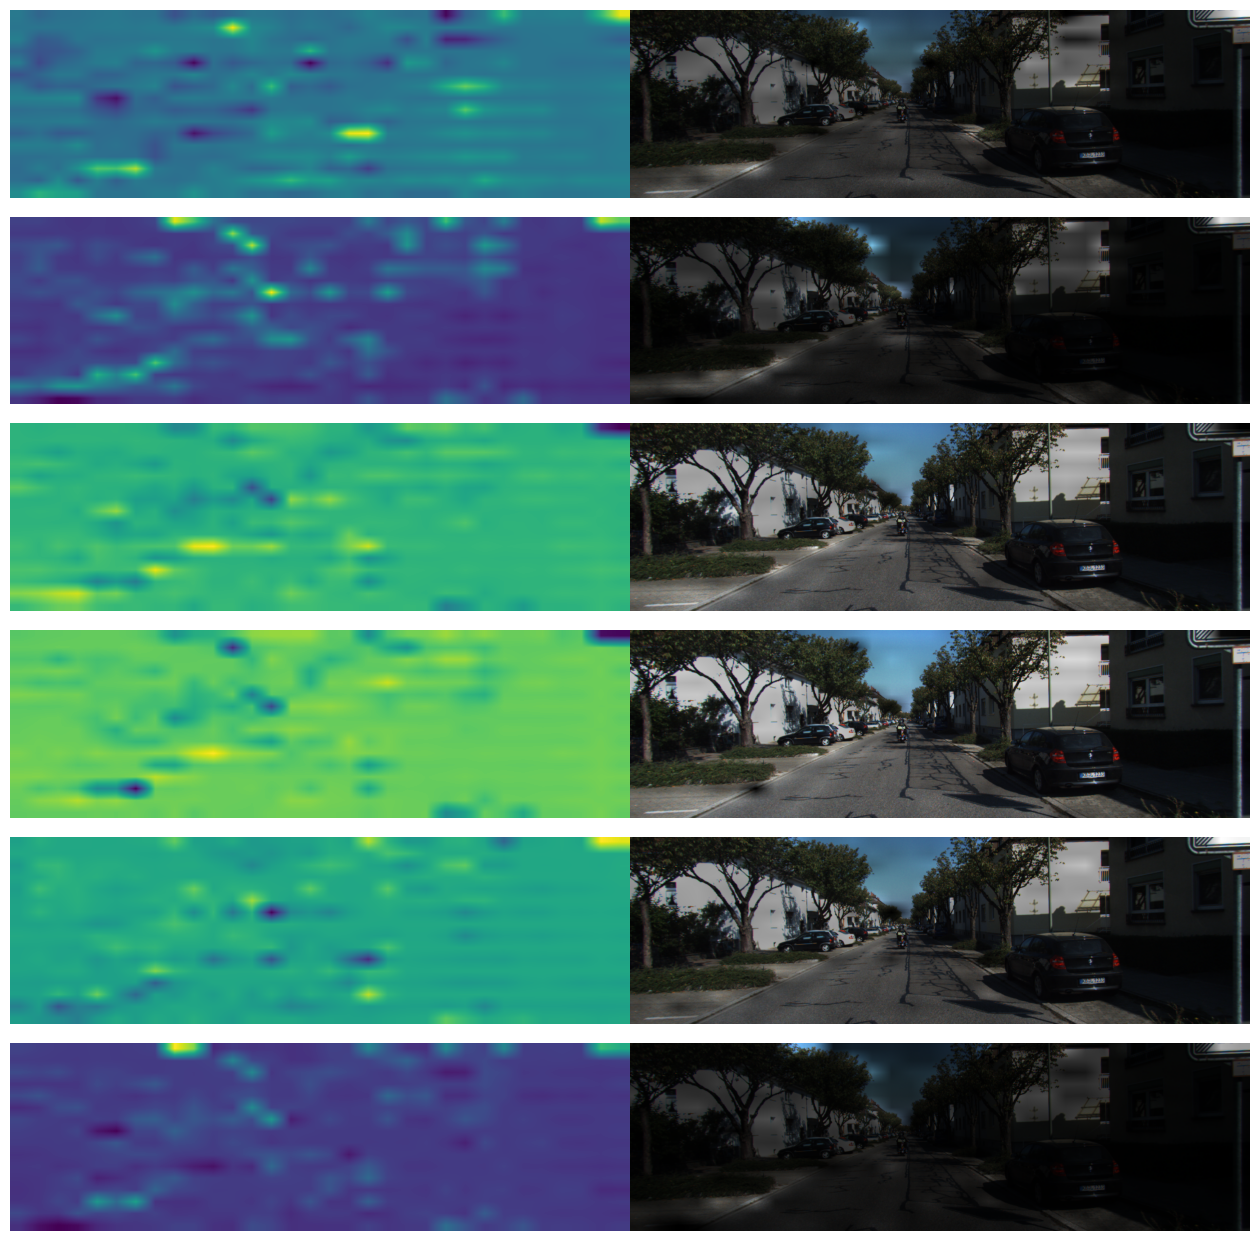

In [20]:
#展示其中一个channel的cam mask和img
# channel = 0-500
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(16, 16))
for i in range(6):
    cam_pred = tscams1[0,0,100*i].detach().cpu().numpy()
    mask_pred = cv2.resize(cam_pred, im0.size)
    mask_min_v, mask_max_v = mask_pred.min(), mask_pred.max()
    mask_pred = (mask_pred - mask_min_v) / (mask_max_v - mask_min_v)
    mask_image = (mask_pred[..., np.newaxis] * im0).astype("uint8")

    axes[i][0].imshow(mask_pred)
    axes[i][0].axis('off')
    axes[i][1].imshow(mask_image)
    axes[i][1].axis('off')
plt.subplots_adjust(wspace=0.001, hspace=0.04)
plt.show()
# %matplotlib inline

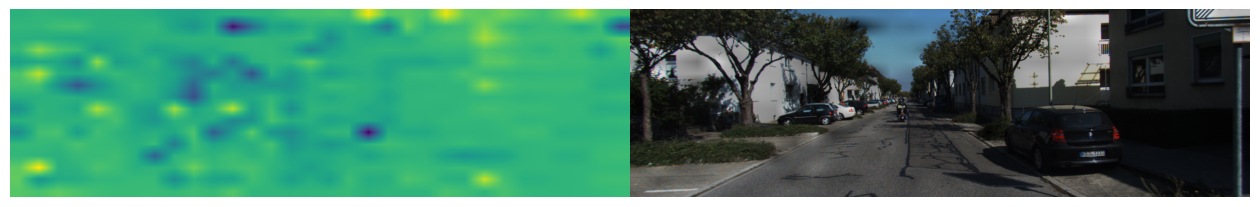

In [14]:
i=0#plot一个channel
fig, axes = plt.subplots(ncols=2, figsize=(16, 16))
cam_pred = tscams[0,0,100*i].detach().cpu().numpy()
mask_pred = cv2.resize(cam_pred, im0.size)
mask_min_v, mask_max_v = mask_pred.min(), mask_pred.max()
mask_pred = (mask_pred - mask_min_v) / (mask_max_v - mask_min_v)
mask_image = (mask_pred[..., np.newaxis] * im0).astype("uint8")
axes[0].imshow(mask_pred)
axes[0].axis('off')
axes[1].imshow(mask_image)
axes[1].axis('off')
plt.subplots_adjust(wspace=0.001, hspace=0.04)
plt.show()
%matplotlib inline


(-0.5, 1240.5, 375.5, -0.5)

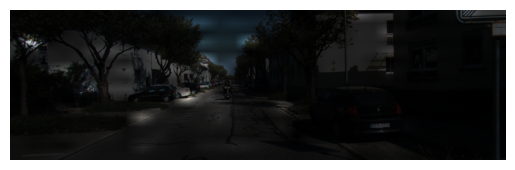

In [34]:
plt.imshow(mask_image)
plt.axis('off')

In [ ]:
"""
Visualize more attention maps from 1-12 layer,for class token
Note: attn_weights is of shape n_layer x n_batch x n_token x n_token
"""
left = 0.1  # the left side of the subplots of the figure
right = 0.9   # the right side of the subplots of the figure
bottom = 0.1  # the bottom of the subplots of the figure
top = 0.45     # the top of the subplots of the figure
wspace = 0.05  # the amount of width reserved for space between subplots,
              # expressed as a fraction of the average axis width
hspace = 0.05  # the amount of height reserved for space between subplots,
              # expressed as a fraction of the average axis height
fig, axes = plt.subplots(nrows=2, ncols=6, figsize=(12, 4.))
#fig.tight_layout()
for row in range(2):
    for col in range(0,6):
        #axes[row][col-1].set_title(str(row)+'-'+str(col))
        attn_l = attn_weights[row*6+col,0][0,1:].reshape(14, 14).detach().cpu().numpy()
        attn_l=cv2.resize(attn_l, (224, 224))
        axes[row][col].imshow(attn_l)
        axes[row][col].axis('off')
#plt.subplots_adjust(left, bottom, right, top, wspace, hspace)
plt.subplots_adjust(wspace=0.001, hspace=0.04)
plt.show()